In [52]:
from collections import defaultdict
import csv
import glob
import math
import os
import string

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

In [53]:
SIZE = 10
SMALL_SIZE = 9
TINY = 7
mpl.rcdefaults()
mpl.rcParams.update({
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsmath,bm,times}',
    'font.family': 'Times New Roman',
    'font.size': SIZE,
    'axes.titlesize': SIZE,
    'axes.labelsize': SMALL_SIZE,
    'ytick.labelsize': TINY,
    'xtick.labelsize': TINY,
    'figure.titlesize': SIZE,
    'legend.fontsize': SMALL_SIZE,
    'svg.fonttype': 'none'
})


# Create an array with the colors you want to use
colors = [
#     "#264653",
    "#2a9d8f",
    "#e9c46a",
    "#f4a261",
#     "#e76f51"
]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

In [183]:
dataset_name_map = {
    'boolq': 'BoolQ',
    'cb-inv': 'CB',
#     'mnli': 'MNLI',
    'mnli-inv': 'MNLI-m',
#     'mnli-mm': 'MNLI',
    'mnli-mm-inv': 'MNLI-mm',
    'mrpc': 'MRPC',
    'qnli': 'QNLI',
    'qqp': 'QQP',
    'rte': 'RTE',
    'rte-inv': 'RTE',
    'sst-2': 'SST-2',
    'wic': 'WiC',
    'wnli': 'WNLI'

}

metric_name_map = {
    'accuracy': 'Accuracy',
    'f1': '$F_1$'
}

finetune_name_map = {
    'all': 'All',
    'bitfit': 'BitFit'
}

PROPS = {
    'boxprops':{'edgecolor':'black', 'linewidth': 1.0},
    'medianprops':{'color':'black', 'linewidth': 1.0},
    'whiskerprops':{'color':'black', 'linewidth': 1.0},
    'capprops':{'color':'black', 'linewidth': 1.0},
    'meanprops':{
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
        "linewidth": 1.0,
        "markersize": 1.0
    },
    'flierprops': {
        "markerfacecolor": "black",
        "markeredgecolor": "black",
        "linewidth": 1.0,
        "markersize": 2.5
    }
}

def plot_no_trigger_results(dataset, finetune_modes, root='crossval-results', **kwargs):
    path = '{root}/{dataset}_model_roberta_initial-trigger_{initial_trigger}_finetune-mode_{finetune_mode}/best_model_scores.csv'
    dfs = []
    metric = 'f1' if dataset in ['cb', 'mrpc', 'qqp'] else 'accuracy'
    for finetune_mode in finetune_modes:
        suffix = '' if finetune_mode not in ['bitfit','layernorm'] else '+trigger'
        
        try:
            manual_trigger = pd.read_csv(path.format(root=root, dataset=dataset, initial_trigger='true', finetune_mode=finetune_mode+suffix))
            manual_trigger['trigger'] = 'Manual Pattern'
            manual_trigger['finetune_mode'] = finetune_name_map[finetune_mode]
            dfs.append(manual_trigger)
        except:
            pass
        

        try:
            no_trigger = pd.read_csv(path.format(root=root, dataset=dataset, initial_trigger='false', finetune_mode=finetune_mode+'-no-trigger'))
            no_trigger['trigger'] = 'Trivial Pattern'
            no_trigger['finetune_mode'] = finetune_name_map[finetune_mode]
            dfs.append(no_trigger)
        except Exception as e:
            print(e)
            pass

#         try:
#             random_trigger = pd.read_csv(path.format(root=root, dataset=dataset, initial_trigger='false', finetune_mode=finetune_mode+suffix))
#             random_trigger['trigger'] = 'Random Init.'
#             random_trigger['finetune_mode'] = finetune_name_map[finetune_mode]
#             dfs.append(random_trigger)
#         except:
#             pass

#         try:
#             no_trigger_w_sep = pd.read_csv(path.format(root=root, dataset=dataset, initial_trigger='false', finetune_mode=finetune_mode+'-no-trigger-sep'))
#             no_trigger_w_sep['trigger'] = 'No Trigger w/ [SEP]'
#             no_trigger_w_sep['finetune_mode'] = finetune_mode
#             dfs.append(no_trigger_w_sep)
#         except:
#             pass

#         try:
#             no_trigger_w_sep = pd.read_csv(path.format(root=root, dataset=dataset, initial_trigger='false', finetune_mode=finetune_mode+'-20-token'))
#             no_trigger_w_sep['trigger'] = 'Random Init. (Big)'
#             no_trigger_w_sep['finetune_mode'] = finetune_name_map[finetune_mode]
#             dfs.append(no_trigger_w_sep)
#         except:
#             pass
        
#         try:
#             no_trigger_w_sep = pd.read_csv(path.format(root=root, dataset=dataset, initial_trigger='false', finetune_mode=finetune_mode+'-20-token-sep'))
#             no_trigger_w_sep['trigger'] = 'Big Trigger w/ [SEP]'
#             no_trigger_w_sep['finetune_mode'] = finetune_mode
#             dfs.append(no_trigger_w_sep)
#         except:
#             pass
    try:
        cls = pd.read_csv(path.format(root=root, dataset=dataset, initial_trigger='false', finetune_mode='cls'))
        cls['trigger'] = 'Std. Fine-tuning'
        cls['finetune_mode'] = finetune_name_map['all']
        dfs.append(cls)
    except:
        pass

    df = pd.concat(dfs)
    df[metric] *= 100
    g = sns.boxplot(
        data=df,
        x='finetune_mode',
        y=metric,
        hue='trigger',
        showmeans=True,
        **PROPS,
        **kwargs,
    )
    g.set(title=dataset_name_map[dataset], ylabel=metric_name_map[metric])


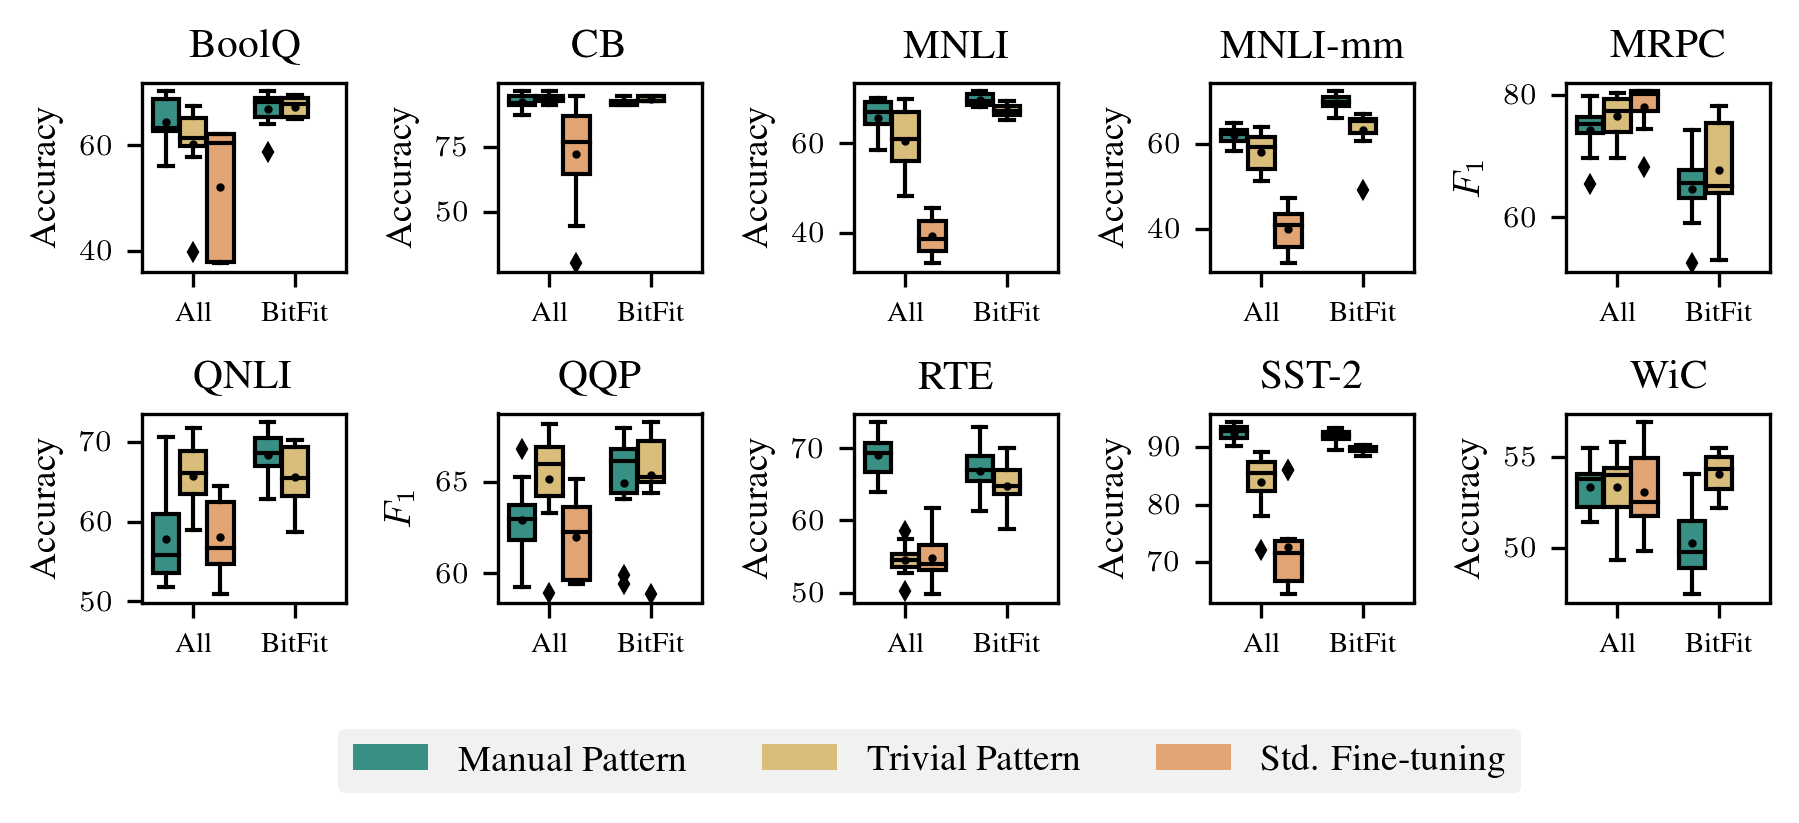

In [55]:
datasets = [
    'boolq',
    'cb-inv',
#     'mnli',
    'mnli-inv',
#     'mnli-mm',
    'mnli-mm-inv',
    'mrpc',
    'qnli',
    'qqp',
#     'rte',
    'rte-inv',
    'sst-2',
    'wic',
#     'wnli'
]
fig, axes = plt.subplots(nrows=math.ceil(len(datasets)/5), ncols=5, figsize=(7.0, 2.25), dpi=300)
axes = np.ravel(axes)
for i, dataset in enumerate(datasets):
    try:
        plot_no_trigger_results(dataset, ['all', 'bitfit'], 'crossval-results', ax=axes[i])
    except Exception as e:
        print(e)
        continue


for ax in axes:
    try:
        ax.get_legend().remove()
        ax.get_xaxis().label.set_visible(False)
    except:
        pass
    
# axes[-2].legend(
#     loc='upper center',
#     bbox_to_anchor=(0.45, -0.5),
#     fancybox=True,
#     shadow=False,
#     ncol=2
# )
# fig.suptitle('RoBERTa Results')


handles, labels = axes[-1].get_legend_handles_labels()
for h in handles:
    h.set_edgecolor(None)
    
legend = fig.legend(
    handles,
    labels,
    loc='lower center',
    ncol=3,
    bbox_to_anchor=(0.5, -0.2),
)
frame = legend.get_frame()
frame.set_linewidth(0.0)
frame.set_facecolor('#EEE')


plt.subplots_adjust(hspace=0.75, wspace=0.75)
plt.savefig('boxplot-null-all.pdf', bbox_inches='tight')
# plt.tight_layout()

/home/rlogan/miniconda3/envs/autoprompt/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


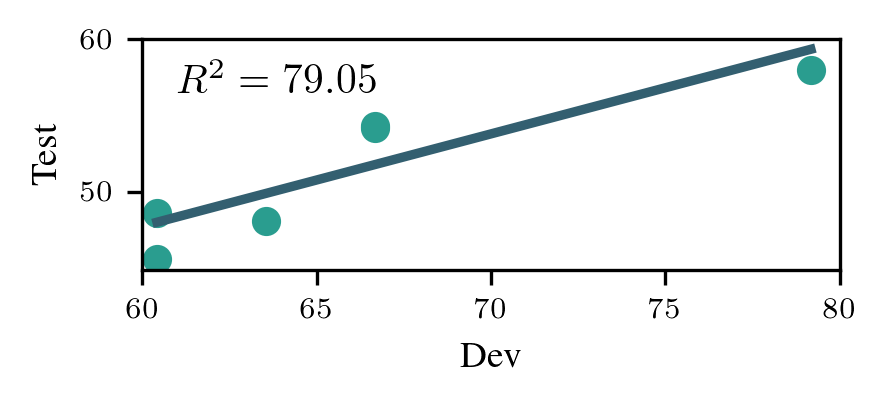

In [143]:
corr = {
    'hmp': (54.17, 66.67),
    'pmh': (57.98, 79.17),
    'mph': (48.08, 63.54),
    'mhp': (48.62, 60.42),
    'phm': (54.30, 66.67),
    'hpm': (45.56, 60.42)
}
x = [e[0] for e in corr.values()]
y = [e[1] for e in corr.values()]

from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

fig, ax = plt.subplots(1, 1, figsize=(3,1), dpi=300)
sns.regplot(y, x, ax=ax, ci=None, scatter_kws={'color': colors[1], 'alpha': 1.0})
ax.set_xlim(60,80)
ax.text(61, 56.5, f'$R^2 = {100*r2(x, y):0.2f}$')
ax.set_xlabel('Dev')
ax.set_ylabel('Test')

plt.savefig('fig/mnli-rsquared.pdf', bbox_inches='tight')

# Win Computation Illustration

In [56]:
def get_scores(fname, key):
    scores = []
    with open(fname, 'r') as f:
        reader = csv.DictReader(f)
        for line in reader:
            scores.append(float(line[key]))
    return np.array(scores)


def p_matrix(
    inputs,
    key,
    invert_yaxis=False
):
    n = len(inputs)
    all_scores = {inp: get_scores(inp, key=key) for inp in inputs}
    diffs = np.zeros((n, n))
    p_values = np.zeros((n, n))
    for i, row in enumerate(inputs):
        for j, col in enumerate(inputs):
            diffs[i][j] = all_scores[row].mean() - all_scores[col].mean()
            _, p_value = scipy.stats.ttest_ind(
                all_scores[row],
                all_scores[col],
                alternative='greater',
                equal_var=False
            )
            p_values[i][j] = p_value
    if invert_yaxis:
        diffs = diffs[::-1,:]
        p_values = p_values[::-1,:]
    return diffs, p_values


DEFAULT_IMSHOW_KWARGS = {
    'cmap': mpl.colors.ListedColormap([colors[0], colors[1], '#000']),
    'edgecolors': 'k'
}

DEFAULT_TEXT_KWARGS = {
    'va': 'center',
    'ha': 'center',
}


def plot_wins(
    ax,
    inputs,
    shortlabs,
    key,
    p_cutoff=0.05,
    imshow_kwargs=DEFAULT_IMSHOW_KWARGS,
    text_kwargs=DEFAULT_TEXT_KWARGS,
    add_wins=False
):
    diffs, p_values = p_matrix(inputs, key=key, invert_yaxis=True)
    color = 1*(p_values < p_cutoff)
    color[np.eye(color.shape[0], dtype=np.bool)[:,::-1]] = 2
    ax.pcolor(color, **imshow_kwargs)
    
    # Plot values over colored cells
    x_ = np.arange(p_values.shape[0])
    y_ = np.arange(p_values.shape[1])
    x, y = np.meshgrid(x_, y_)
    for i, j in zip(x.flatten(), y.flatten()):
        if i == (p_values.shape[1] - j - 1):
            continue
        ax.text(j + 0.5, i + 0.666, f"{100*diffs[i,j]:+0.1f}", fontsize=TINY, **text_kwargs)
        ax.text(j + 0.5, i + 0.333, f"({p_values[i,j]:0.2f})", fontsize=TINY - 2, **text_kwargs)
    
    # Add a "wins column"
    if add_wins:
        wins = (p_values < p_cutoff).sum(axis=-1)
        for i in (y.flatten()):
            ax.text(x_[-1] + 1.75, i + 0.5, f"{wins[i]}", fontsize=TINY, **text_kwargs)
        
    # Cleanup plot
    ax.set_xticks(x_ + 0.5)
    ax.set_xticklabels([shortlabs[i] for i in range(len(x_))])
    ax.set_yticks(y_ + 0.5)
    ax.set_yticklabels([shortlabs[i] for i in reversed(range(len(y_)))])
    ax.tick_params(
        top=False,
        bottom=False,
        left=False,
        right=False,
        labelbottom=False,
        labeltop=True,
    )
    ax.xaxis.set_label_position('top')


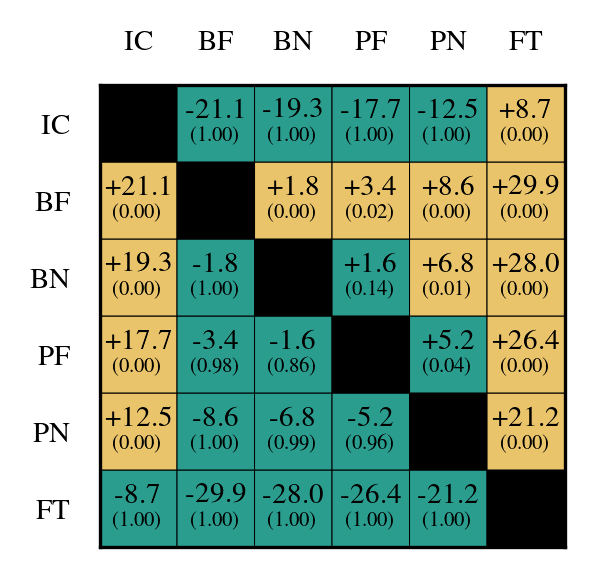

In [57]:
fig, ax = plt.subplots(figsize=(2,2), dpi=300)


# inputs = glob.glob('table2-results/cb-inv*/best_model_scores.csv')
inputs = [
    'table-results/mnli-inv_model_roberta_initial-trigger_true_finetune-mode_in-context/best_model_scores.csv',
    'table-results/mnli-inv_model_roberta_initial-trigger_true_finetune-mode_bitfit/best_model_scores.csv',
    'table-results/mnli-inv_model_roberta_initial-trigger_false_finetune-mode_bitfit-no-trigger/best_model_scores.csv',
    'table-results/mnli-inv_model_roberta_initial-trigger_true_finetune-mode_all/best_model_scores.csv',
    'table-results/mnli-inv_model_roberta_initial-trigger_false_finetune-mode_all-no-trigger/best_model_scores.csv',
    'table-results/mnli-inv_model_roberta_initial-trigger_false_finetune-mode_cls/best_model_scores.csv',
]

shortlabs = [
    'IC',
    'BF',
    'BN',
    'PF',
    'PN',
    'FT'
]

plot_wins(
    ax,
    p_cutoff=0.025,
    inputs=inputs,
    shortlabs=shortlabs,
    key='accuracy'
)

plt.savefig('fig/pairwise-comparisons.svg', bbox_inches='tight')


# Bar Plots

In [71]:
ROOT_DIR = 'crossval-results'
RESULTS_FILE = 'best_model_scores.csv'
NCOL = 2
MODEL_NAMES = {
    'roberta': 'RoBERTa (Large)',
    'albert': 'ALBERT (XXLarge-V2)'
}


def load_ablations(dataset, model, ablation_dirs):
    dfs = []
    for key, directory in ablation_dirs.items():
        directory = directory.format(
            dataset=dataset,
            model=model,
        )
        path = os.path.join(ROOT_DIR, directory, RESULTS_FILE)
        try:
            df = pd.read_csv(path)
        except:
            print(f'There is a problem at: {path}')
            continue
        df['key'] = key
        df['dataset'] = dataset_name_map[dataset]
        metric = 'f1' if 'f1' in df else 'accuracy'
        df['metric'] = 100 * df[metric]
        dfs.append(df)
    df = pd.concat(dfs)
    return df


# def _resort(x):
#     div = len(x) // NCOL
#     indexes = []
#     for j in range(NCOL):
#         for i in range(div):
#             indexes.append(NCOL * i + j + 1) 
#     indexed = list(zip(indexes, x))
#     resorted = sorted(indexed, key=lambda x: x[0])
#     print(resorted)
#     return [x[1] for x in resorted]


def plot_ablations(ax, datasets, model, ablation_dirs, legend=False, title=True):
    df = pd.concat(load_ablations(dataset, model, ablation_dirs) for dataset in datasets)
    sns.barplot(
        data=df,
        x='dataset',
        y='metric',
        hue='key',
        ax=ax,
        errcolor='k',
        errwidth=1.0
    )
    
    # Make pretty
    if title:
        ax.set_title(MODEL_NAMES[model])
    ax.set_yticks([0, 25, 50, 75, 100])
    sns.despine(ax=ax, top=True, right=True)
    ax.tick_params(bottom=False)
    ax.set_xlabel('')
    ax.tick_params(axis='x', labelrotation = 45)
    ax.set_ylabel('')
    
#     if legend:
#         # Make legend read left-to-right before top-to-bottom.
# #         handles, labels = ax.get_legend_handles_labels()
# #         handles = _resort(handles)
# #         labels = _resort(labels)
#         legend = ax.legend(
# #             handles,
# #             labels,
#             fontsize=TINY,
#             loc='upper center',
#             ncol=NCOL,
#             bbox_to_anchor=(0.5, -0.75))
#         frame = legend.get_frame()
#         frame.set_linewidth(0.0)
#     else:
    ax.get_legend().remove()
        
        
def plot_wins(ax, datasets, model, ablation_dirs, p_cutoff=0.025):
    df = pd.concat(load_ablations(dataset, model, ablation_dirs) for dataset in datasets)
    out_df = pd.DataFrame({'key': df.key.unique()})
    out_df['wins'] = 0
    n = len(out_df)
    for dataset, group in df.groupby('dataset'):
        p_values = np.zeros((n, n))
        for i, source in enumerate(group.key.unique()):
            for j, target in enumerate(group.key.unique()):
                source_metric = (group[group.key==source]['metric']).to_numpy()
                target_metric = (group[group.key==target]['metric']).to_numpy()
                _, p_value = scipy.stats.ttest_ind(
                    source_metric,
                    target_metric,
                    alternative='greater',
                    equal_var=False
                )
                p_values[i][j] = p_value
        signif = (p_values < p_cutoff).sum(axis=-1)   
        best = np.max(signif)
        for i, key in enumerate(group.key.unique()):
            if signif[i] == best:
                out_df.loc[out_df['key'] == key, 'wins'] +=1
    sns.barplot(
        data=out_df,
        x='key',
        y='wins',
        ax=ax,
        errcolor='k',
        errwidth=1.0
    )
    sns.despine(ax=ax, top=True, left=True, right=False)
    ax.tick_params(bottom=False)
    ax.set_xlabel('\# Wins')
    ax.set_xticks([])
    ax.set_ylabel('')
    ax.yaxis.get_major_locator().set_params(integer=True)
    ax.yaxis.set_label_position("right")
            

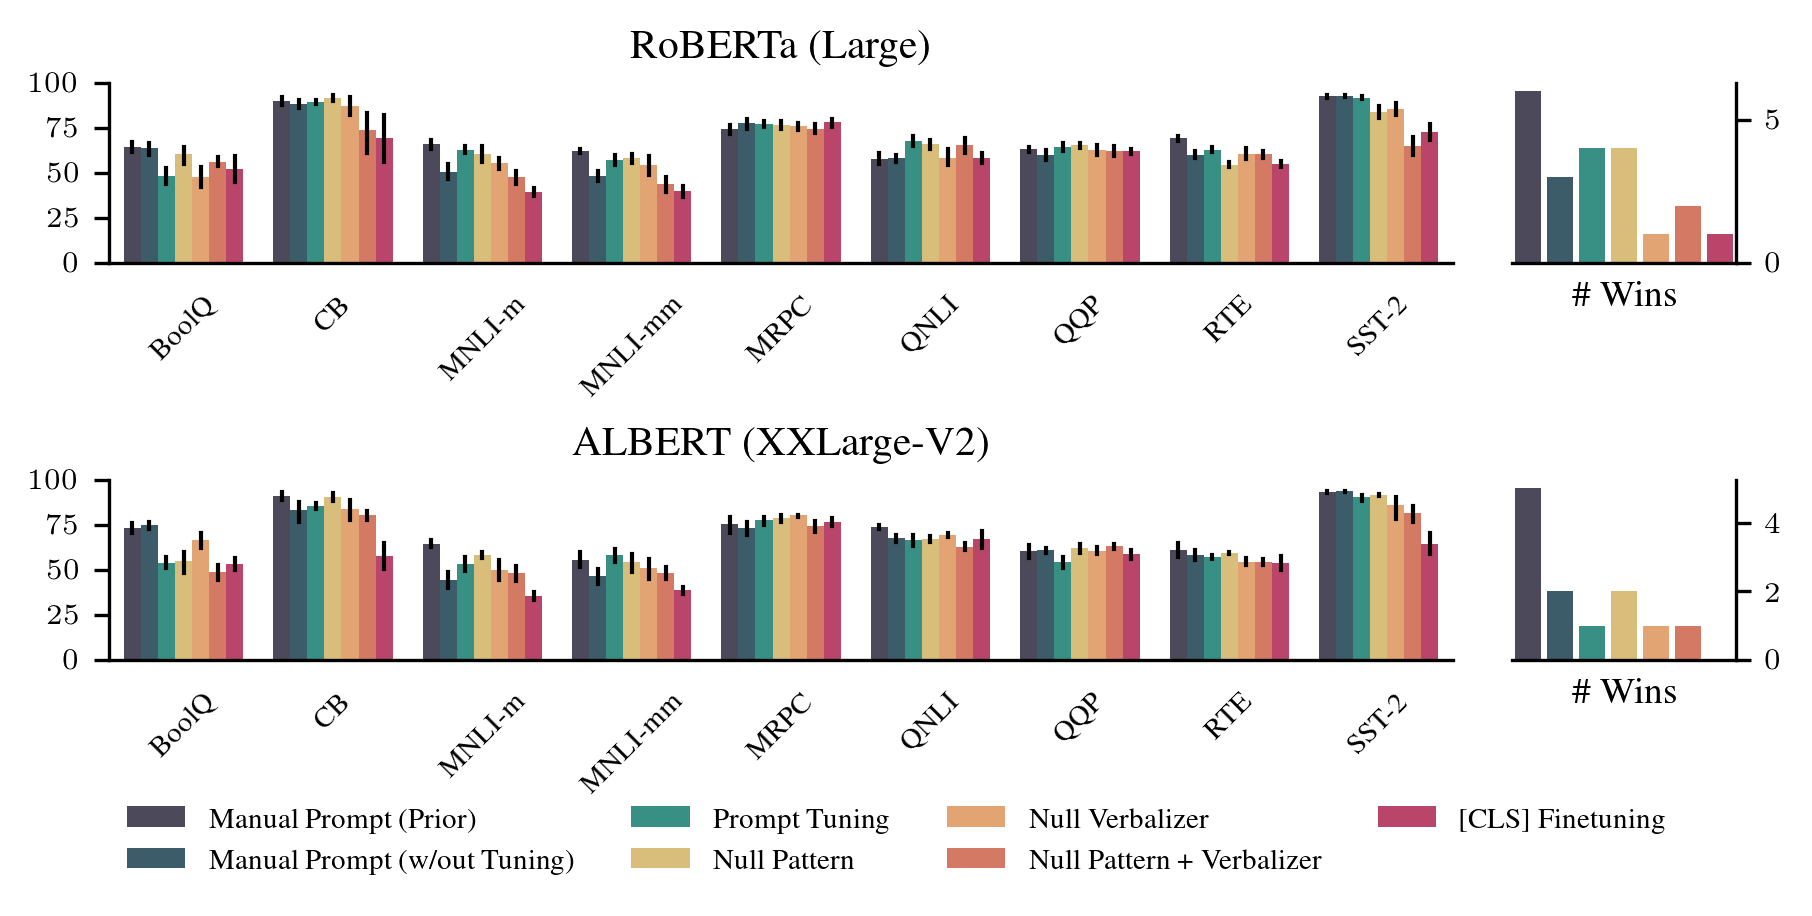

In [184]:
# Need more colors for 4-bar plot
colors = [
    "#4A465D",
    "#335F70",
    "#2a9d8f",
    "#e9c46a",
    "#f4a261",
    "#e76f51",
    "#CC3363"
]
sns.set_palette(sns.color_palette(colors))


# Primary approach for plot
datasets = [
    'boolq',
    'cb-inv',
    'mnli-inv',
    'mnli-mm-inv',
    'mrpc',
    'qnli',
    'qqp',
    'rte-inv',
    'sst-2'
]

ablation_dirs = {
    'Manual Prompt (Prior)': '{dataset}_model_{model}_initial-trigger_true_finetune-mode_all',
    'Manual Prompt (w/out Tuning)': '{dataset}_model_{model}_initial-trigger_true_finetune-mode_all-var1',
#     'In-Context': '{dataset}_model_{model}_initial-trigger_true_finetune-mode_all-ic',
    'Prompt Tuning': '{dataset}_model_{model}_initial-trigger_false_finetune-mode_all',
    'Null Pattern': '{dataset}_model_{model}_initial-trigger_false_finetune-mode_all-no-trigger',
    'Null Verbalizer': '{dataset}_model_{model}_initial-trigger_true_finetune-mode_all-random-labels',
    'Null Pattern + Verbalizer': '{dataset}_model_{model}_initial-trigger_false_finetune-mode_all-no-trigger-random-labels',
    '[CLS] Finetuning': '{dataset}_model_{model}_initial-trigger_false_finetune-mode_cls',
}

fig, ax = plt.subplots(2, 2, figsize=(7,2.5), dpi=300, gridspec_kw={"width_ratios":[6,1]})

plot_ablations(ax[0,0], datasets, 'roberta', ablation_dirs)
plot_wins(ax[0,1], datasets, 'roberta', ablation_dirs)
plot_ablations(ax[1,0], datasets, 'albert', ablation_dirs)
plot_wins(ax[1,1], datasets, 'albert', ablation_dirs)

handles, labels = ax[0,0].get_legend_handles_labels()
legend = fig.legend(
    handles,
    labels,
    fontsize=TINY,
    loc='upper center',
    ncol=4,
    bbox_to_anchor=(0.5, -.05))
frame = legend.get_frame()
frame.set_linewidth(0.0)
plt.subplots_adjust(hspace=1.2, wspace=0.075)

plt.savefig('fig/ablations-both-models-2-col.pdf', bbox_inches='tight')

/home/rlogan/miniconda3/envs/autoprompt/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/rlogan/miniconda3/envs/autoprompt/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


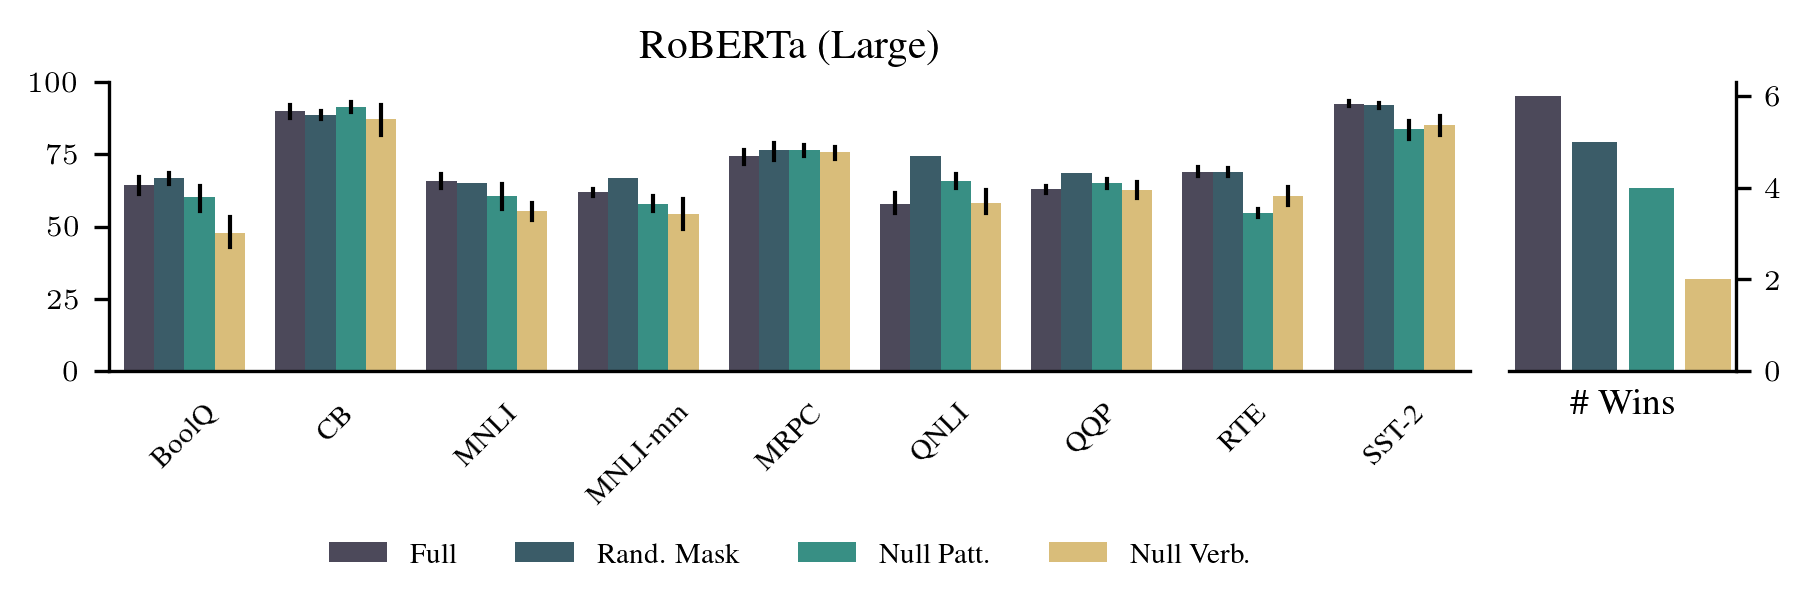

In [133]:
datasets = [
    'boolq',
    'cb-inv',
    'mnli-inv',
    'mnli-mm-inv',
    'mrpc',
    'qnli',
    'qqp',
    'rte-inv',
    'sst-2'
]

ablation_dirs = {
    'Full': '{dataset}_model_{model}_initial-trigger_true_finetune-mode_all',
    'Rand. Mask': '{dataset}_model_{model}_initial-trigger_true_finetune-mode_all-random-masks',
    'Null Patt.': '{dataset}_model_{model}_initial-trigger_false_finetune-mode_all-no-trigger',
    'Null Verb.': '{dataset}_model_{model}_initial-trigger_true_finetune-mode_all-random-labels',
}


fig, ax = plt.subplots(1, 2, figsize=(7,1.25), dpi=300, gridspec_kw={"width_ratios":[6,1]})


plot_ablations(ax[0], datasets, 'roberta', ablation_dirs)
plot_wins(ax[1], datasets, 'roberta', ablation_dirs)

legend = ax[0].legend(
    fontsize=TINY,
    loc='upper center',
    ncol=4,
    bbox_to_anchor=(0.5, -.5))
frame = legend.get_frame()
frame.set_linewidth(0.0)

plt.subplots_adjust(wspace=0.05)


plt.savefig('fig/ablations-alt-2-col.pdf', bbox_inches='tight')

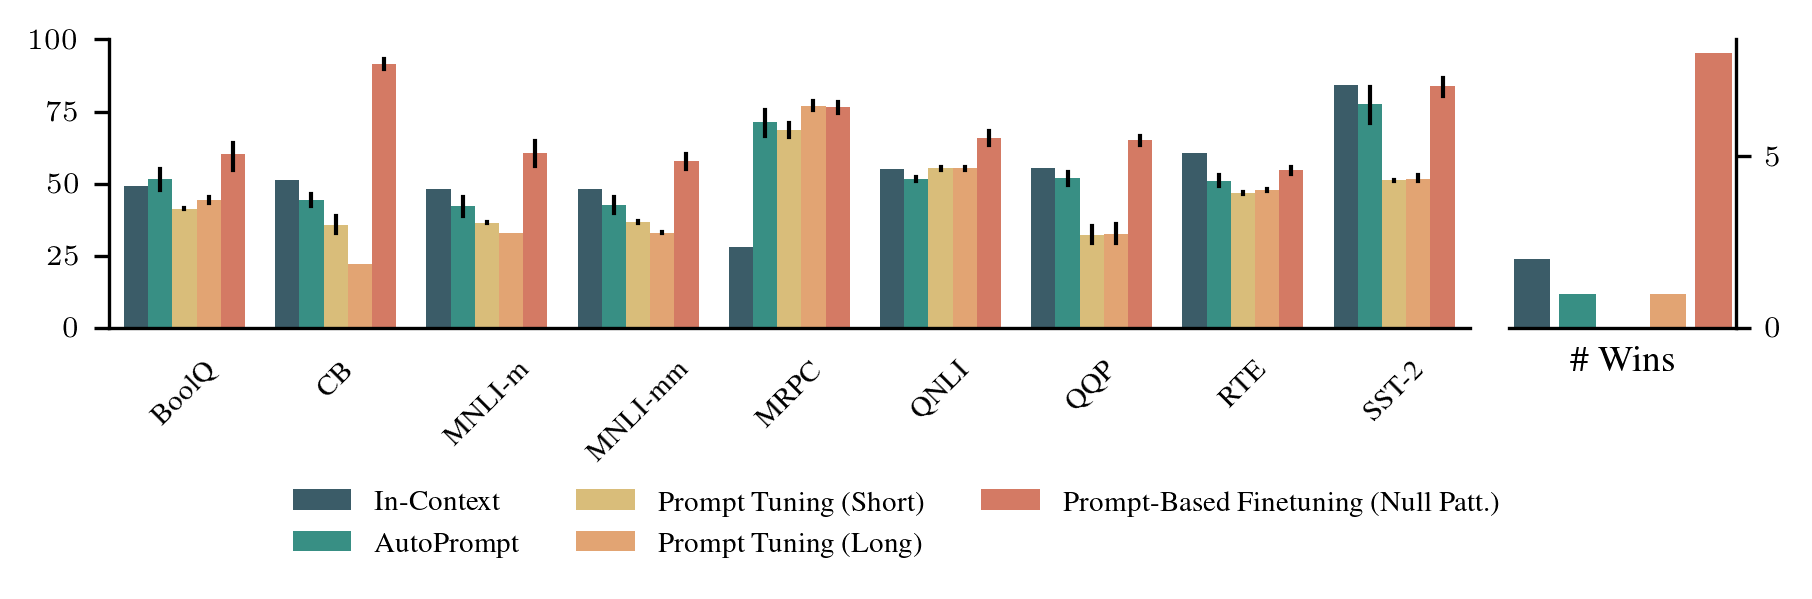

In [185]:
# Need more colors for 6-bar plot
colors = [
#     "#4A465D",
    "#335F70",
    "#2a9d8f",
    "#e9c46a",
    "#f4a261",
    "#e76f51",
    "#CC3363"
]
sns.set_palette(sns.color_palette(colors))

datasets = [
    'boolq',
    'cb-inv',
    'mnli-inv',
    'mnli-mm-inv',
    'mrpc',
    'qnli',
    'qqp',
    'rte-inv',
    'sst-2'
]


ablation_dirs = {
    'In-Context': '{dataset}_model_{model}_initial-trigger_true_finetune-mode_in-context',
    'AutoPrompt': '{dataset}_model_{model}_initial-trigger_true_finetune-mode_discrete',
    'Prompt Tuning (Short)': '{dataset}_model_{model}_initial-trigger_false_finetune-mode_triggers',
    'Prompt Tuning (Long)': '{dataset}_model_{model}_initial-trigger_false_finetune-mode_triggers-20-token',
#     'Prompt + LM Head Tuning': '{dataset}_model_{model}_initial-trigger_true_finetune-mode_partial',
    'Prompt-Based Finetuning (Null Patt.)': '{dataset}_model_{model}_initial-trigger_false_finetune-mode_all-no-trigger',
}

fig, ax = plt.subplots(1, 2, figsize=(7,1.25), dpi=300, gridspec_kw={"width_ratios":[6,1]})


plot_ablations(ax[0], datasets, 'roberta', ablation_dirs, title=False)
plot_wins(ax[1], datasets, 'roberta', ablation_dirs)

handles, labels = ax[0].get_legend_handles_labels()
legend = fig.legend(
    fontsize=TINY,
    loc='upper center',
    ncol=3,
    bbox_to_anchor=(0.5, -.25))
frame = legend.get_frame()
frame.set_linewidth(0.0)

plt.subplots_adjust(wspace=0.05)


plt.savefig('fig/prompt-tuning-2-col.pdf', bbox_inches='tight')

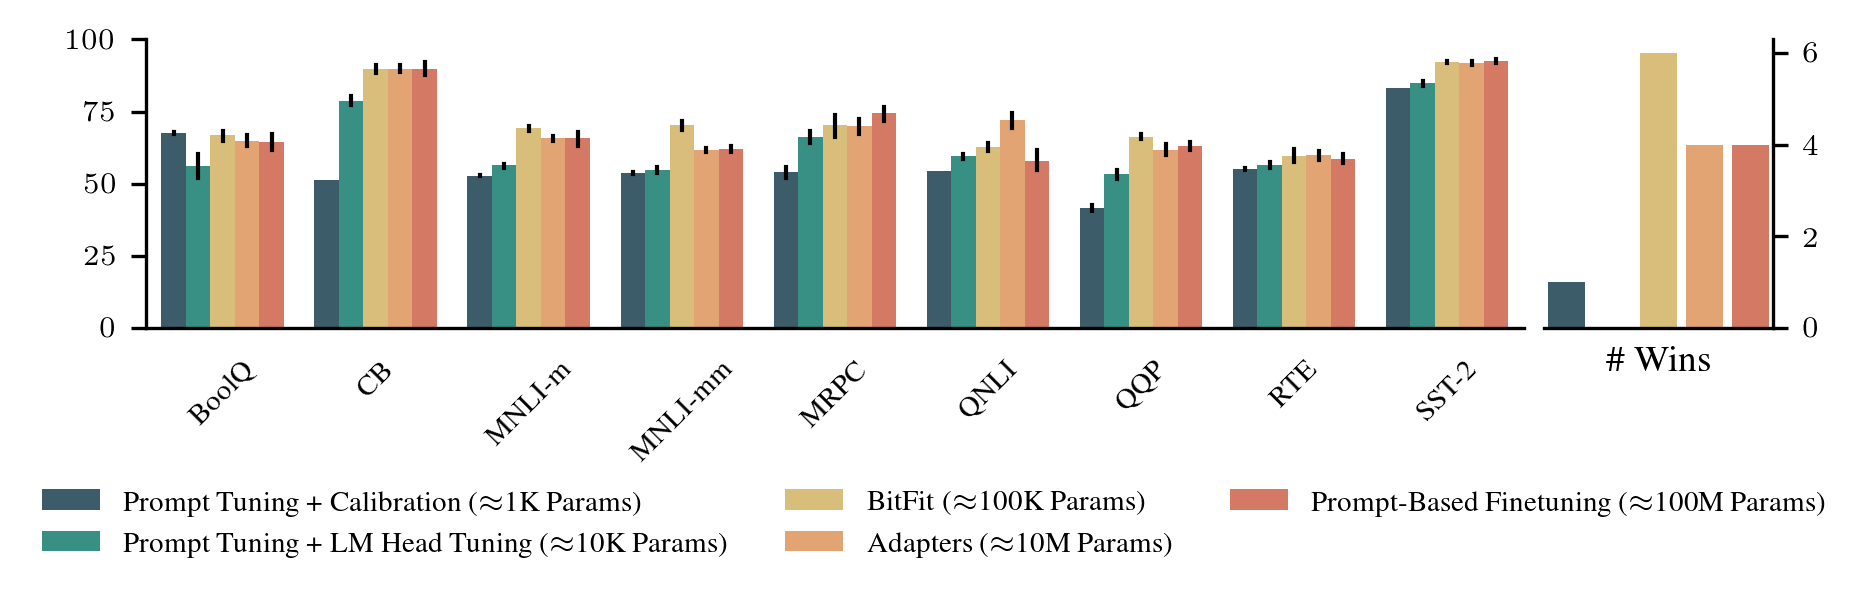

In [189]:
# Need more colors for 6-bar plot
# colors = [
#     "#2A2537",
#     "#264653",
#     "#2a9d8f",
#     "#e9c46a",
#     "#f4a261",
#     "#e76f51"
# ]
# sns.set_palette(sns.color_palette(colors))

datasets = [
    'boolq',
    'cb-inv',
    'mnli-inv',
    'mnli-mm-inv',
    'mrpc',
    'qnli',
    'qqp',
    'rte',
    'sst-2'
]


ablation_dirs = {
    r'Prompt Tuning + Calibration ($\approx$1K Params)': '{dataset}_model_{model}_initial-trigger_true_finetune-mode_calibration',
    r'Prompt Tuning + LM Head Tuning ($\approx$10K Params)': '{dataset}_model_{model}_initial-trigger_true_finetune-mode_partial',
    r'BitFit ($\approx$100K Params)': '{dataset}_model_{model}_initial-trigger_true_finetune-mode_bitfit',
    r'Adapters ($\approx$10M Params)': '{dataset}_model_{model}_initial-trigger_true_finetune-mode_adapter+trigger',
    r'Prompt-Based Finetuning ($\approx$100M Params)': '{dataset}_model_{model}_initial-trigger_true_finetune-mode_all',
}

fig, ax = plt.subplots(1, 2, figsize=(7,1.25), dpi=300, gridspec_kw={"width_ratios":[6,1]})


plot_ablations(ax[0], datasets, 'roberta', ablation_dirs, title=False)
plot_wins(ax[1], datasets, 'roberta', ablation_dirs)

handles, labels = ax[0].get_legend_handles_labels()
legend = fig.legend(
    fontsize=TINY,
    loc='upper center',
    ncol=3,
    bbox_to_anchor=(0.5, -.25))
frame = legend.get_frame()
frame.set_linewidth(0.0)

plt.subplots_adjust(wspace=0.025)



plt.savefig('fig/parameter-efficient-tuning-2-col.pdf', bbox_inches='tight')

## Hook Fig?

In [ ]:
##### For reference
colors = [
    "#264653",
    "#2a9d8f",
    "#e9c46a",
    "#f4a261",
    "#e76f51"
]

fig, ax = plt.subplots(3, 1, figsize=(2.2, 2.0), dpi=300, sharex=True)

x = np.arange(3)
params = np.array([1.75e11, 2.23e8, 3.35e8])
finetuned = np.array([0.0, 100, 0.09])
cb = np.array([51.2, 90.6, 90.6])
qqp = np.array([55.6, 62.9, 65.1])


def log_format(y, pos):
    # Find the number of decimal places required
    decimalplaces = int(np.maximum(-np.log10(y),0))     # =0 for numbers >=1
    # Insert that number into a format string
    formatstring = '{{:.{:1d}f}}'.format(decimalplaces)
    # Return the formatted tick label
    return formatstring.format(y)

# ax[0].bar(x, params, color=colors[1:4])
# ax[0].set_ylim(1e6, 1e12)
# ax[0].set_yscale('log')
# ax[0].set_title('Number of Parameters')
# ax[0].xaxis.set_visible(False)
# ax[0].set_yticks([1e6, 1e9, 1e12])
# ax[0].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(log_format))

sns.despine(ax=ax[0])

def log_perc_format(y, pos):
    # Find the number of decimal places required
    decimalplaces = int(np.maximum(-np.log10(y),0))     # =0 for numbers >=1
    # Insert that number into a format string
    formatstring = '{{:.{:1d}f}}\%'.format(decimalplaces)
    # Return the formatted tick label
    return formatstring.format(y)

ax[0].bar(x, finetuned, color=colors[:3])
for i, p in enumerate(ax[0].patches):
    width = p.get_width()
    if i == 0:
        y = 0.0
        height = 0.1
    else:
        y = p.get_y()
        height = p.get_height()
    ax[0].annotate(
        f'{finetuned[i]:.1f}',
        (p.get_x() + 0.5 * width, y + height * (1.25)),
        fontsize=TINY,
        ha='center'
    )
ax[0].set_yscale('log')
ax[0].set_title('Finetuned Params', pad=7, fontsize=8)
# ax[0].set_ylabel('Tuned\nParams', fontsize=TINY)
ax[0].set_yticks([1e2, 1e1, 1e0, 1e-1])
ax[0].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(log_perc_format))
ax[0].xaxis.set_visible(False)
sns.despine(ax=ax[1])

rect = ax[1].bar(x, cb, color=colors[:3])
ax[1].bar_label(rect, fontsize=TINY)
ax[1].set_title('CB ($F_1$)', pad=7, fontsize=8)
# ax[1].set_ylabel('CB\n$F_1$', fontsize=TINY)
ax[1].set_ylim(0, 100)
ax[1].tick_params(bottom=False)
ax[1].set_yticks([0, 50, 100])
ax[1].set_xticks([0,1,2])
sns.despine(ax=ax[2])

rect = ax[2].bar(x, qqp, color=colors[:3])
ax[2].bar_label(rect, fontsize=TINY)
ax[2].set_title('QQP ($F_1$)', pad=7, fontsize=8)
# ax[2].set_ylabel('QQP\n$F_1$', fontsize=TINY)
ax[2].set_ylim(0, 75)
ax[2].tick_params(bottom=False)
ax[2].set_yticks([0, 25, 50, 75])
ax[2].set_xticks([0,1,2])
ax[2].set_xticklabels(['In-Context', 'Prompt-Based\nFinetuning', 'Ours'])
sns.despine(ax=ax[2])

# from matplotlib.lines import Line2D
# custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
#                 Line2D([0], [0], color=colors[1], lw=4),
#                 Line2D([0], [0], color=colors[2], lw=4)]
# legend = fig.legend(
#     custom_lines,
#     ['In-Context', 'Prompt-Based\nFinetuning', 'Ours'],
#     loc='center',
#     bbox_to_anchor=(0.5,0.0),
#     fontsize=TINY,
#     ncol=3
# )
# frame = legend.get_frame()
# frame.set_linewidth(0.0)

plt.subplots_adjust(hspace=1.0)
plt.savefig('fig/hook-left.pdf', bbox_inches='tight')